# **Relação entre gastos militares das nações e seu impacto econômico: positivo ou negativo?**

---


# 1) Importando e tratando os dados

In [14]:
from google.colab import files

uploaded = files.upload()

Saving dataset_2025-06-04T01_01_07.768164706Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0.csv to dataset_2025-06-04T01_01_07.768164706Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0 (4).csv
Saving SIPRI-Milex-data-2014-2024 v2.xlsx to SIPRI-Milex-data-2014-2024 v2 (4).xlsx
Saving SIPRI-Milex-data-2014-2024.xlsx to SIPRI-Milex-data-2014-2024 (4).xlsx


In [17]:
import pandas as pd

# importando as bases de dados de seus respctivos caminhos
sipri_data = pd.read_excel(
    'SIPRI-Milex-data-2014-2024.xlsx',
    sheet_name=[
        'Constant (2023) US$', 'Current US$', 'Share of GDP',
        'Per capita', 'Share of Govt. spending'
    ]
)
fmi_data = pd.read_csv('dataset_2025-06-04T01_01_07.768164706Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0.csv')


# a) Tratando a base sipri_data

In [18]:
# passando os dados para o formato long com .melt(), de modo que um ano esteja associado a mais de uma variável
constant_exp_long = sipri_data['Constant (2023) US$'].melt(id_vars=['Country'], var_name='Year', value_name='militar_expenses')
current_exp_long = sipri_data['Current US$'].melt(id_vars=['Country'], var_name='Year', value_name='militar_expenses_cur')
gdp_share_long = sipri_data['Share of GDP'].melt(id_vars=['Country'], var_name='Year', value_name='expenses_share_of_gdp')
percap_exp_long = sipri_data['Per capita'].melt(id_vars=['Country'], var_name='Year', value_name='expenses_per_capita')
govspend_long = sipri_data['Share of Govt. spending'].melt(id_vars=['Country'], var_name='Year', value_name='expenses_share_of_gov')

# definindo e aplicando a função clean para converter valores não numéricos e eliminá-los se nulos
def clean(df, value_col):
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
    df['Year'] = df['Year'].astype(int)
    return df

constant_exp_long = clean(constant_exp_long, 'militar_expenses')
current_exp_long = clean(current_exp_long, 'militar_expenses_cur')
gdp_share_long = clean(gdp_share_long, 'expenses_share_of_gdp')
percap_exp_long = clean(percap_exp_long, 'expenses_per_capita')
govspend_long = clean(govspend_long, 'expenses_share_of_gov')

# mergindo cada uma delas sucessivamente até termos um único dataframe
military_expenses = constant_exp_long.merge(current_exp_long, on=['Country', 'Year'], how='outer')
military_expenses = military_expenses.merge(gdp_share_long, on=['Country', 'Year'], how='outer')
military_expenses = military_expenses.merge(percap_exp_long, on=['Country', 'Year'], how='outer')
military_expenses = military_expenses.merge(govspend_long, on=['Country', 'Year'], how='outer')

# remover linhas nulas e verificando se funcionou com .sum()
military_expenses = military_expenses.dropna(subset=[
    'militar_expenses', 'militar_expenses_cur',
    'expenses_share_of_gdp', 'expenses_per_capita',
    'expenses_share_of_gov'
])

print(military_expenses.isna().sum())

# verificando nosso df final
print(military_expenses.info())
print(military_expenses.head())

Country                  0
Year                     0
militar_expenses         0
militar_expenses_cur     0
expenses_share_of_gdp    0
expenses_per_capita      0
expenses_share_of_gov    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1640 entries, 0 to 2100
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                1640 non-null   object 
 1   Year                   1640 non-null   int64  
 2   militar_expenses       1640 non-null   float64
 3   militar_expenses_cur   1640 non-null   float64
 4   expenses_share_of_gdp  1640 non-null   float64
 5   expenses_per_capita    1640 non-null   float64
 6   expenses_share_of_gov  1640 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 102.5+ KB
None
       Country  Year  militar_expenses  militar_expenses_cur  \
0  Afghanistan  2014        245.148024            268.238788   
1  Afghanistan  2015        196.

# b) Tratando a base fmi_data

In [21]:
import pandas as pd
# removendo colunas desnecessárias do df e renomeando a coluna 'COUNTRY' para o merge
fmi_data = fmi_data.drop(columns=['DATASET','SERIES_CODE', 'OBS_MEASURE', 'FREQUENCY', 'SCALE'])
fmi_data = fmi_data.rename(columns={'COUNTRY':'Country'})

# passando os dados para o formato long com .melt(), de modo que um ano esteja associado a mais de uma variável
col_years = ['2014', '2015', '2016', '2017', '2018', '2019','2020','2021','2022','2023','2024']
fmi_data_melt = fmi_data.melt(
    id_vars=['Country', 'INDICATOR'],
    value_vars=col_years,
    var_name='Year',
    value_name='Value'
)
# criando uma coluna para cada indicador com a função .pivot()
fmi_data_pivot_melt = fmi_data_melt.pivot(
    index=['Country', 'Year'],
    columns='INDICATOR',
    values= 'Value'
)




print(fmi_data_pivot_melt.head())

INDICATOR     External debt, Percent of GDP  External debt, US dollar  \
Country Year                                                            
ASEAN-5 2014                            NaN                       NaN   
        2015                            NaN                       NaN   
        2016                            NaN                       NaN   
        2017                            NaN                       NaN   
        2018                            NaN                       NaN   

INDICATOR     Gross debt, General government, Percent of GDP  \
Country Year                                                   
ASEAN-5 2014                                          45.097   
        2015                                          46.503   
        2016                                          46.584   
        2017                                          47.129   
        2018                                          48.377   

INDICATOR     Gross domestic product (G

In [24]:
# mergindo os dois dfs

tabelona = pd.merge(military_expenses, fmi_data_pivot_melt, on='Country', how='outer')

print(tabelona.head())

   Country  Year  militar_expenses  militar_expenses_cur  \
0  ASEAN-5   NaN               NaN                   NaN   
1  ASEAN-5   NaN               NaN                   NaN   
2  ASEAN-5   NaN               NaN                   NaN   
3  ASEAN-5   NaN               NaN                   NaN   
4  ASEAN-5   NaN               NaN                   NaN   

   expenses_share_of_gdp  expenses_per_capita  expenses_share_of_gov  \
0                    NaN                  NaN                    NaN   
1                    NaN                  NaN                    NaN   
2                    NaN                  NaN                    NaN   
3                    NaN                  NaN                    NaN   
4                    NaN                  NaN                    NaN   

   External debt, Percent of GDP  External debt, US dollar  \
0                            NaN                       NaN   
1                            NaN                       NaN   
2                   

Buscando Correlações

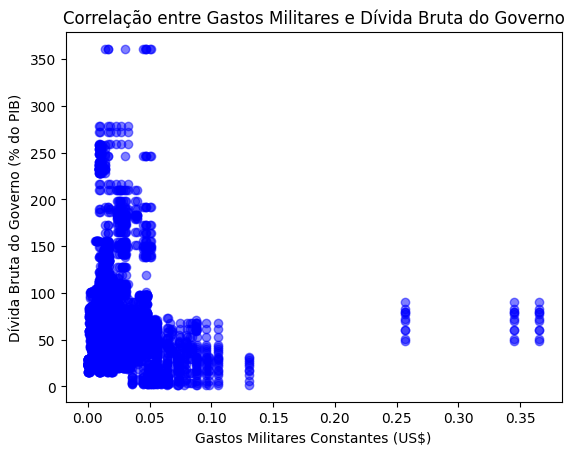

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

tabelona_gastos_divida = tabelona[['expenses_share_of_gdp', 'Gross debt, General government, Percent of GDP']].dropna()
plt.scatter(tabelona_gastos_divida ['expenses_share_of_gdp'], tabelona_gastos_divida ['Gross debt, General government, Percent of GDP'], color='blue', alpha=0.5)
plt.xlabel('Gastos Militares Constantes (US$)')
plt.ylabel('Dívida Bruta do Governo (% do PIB)')
plt.title('Correlação entre Gastos Militares e Dívida Bruta do Governo')
plt.show()


In [56]:
#examinando relação entre gastos militares e dívida do governo
import numpy as np
from scipy.stats import pearsonr
x=tabelona_gastos_divida['expenses_share_of_gdp']
y= tabelona_gastos_divida ['Gross debt, General government, Percent of GDP']

corr_coef, p_value= pearsonr(x,y)
print(corr_coef)
print(p_value)

-0.009799948112329319
0.2687407637232268


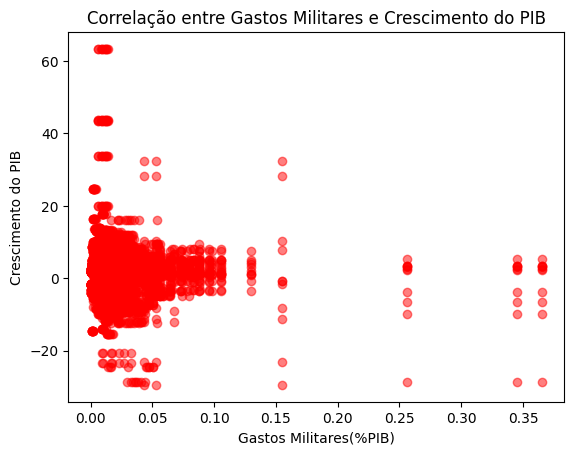

In [49]:
tabelona_gastos_crescimentoPIB = tabelona[['expenses_share_of_gdp', 'Gross domestic product (GDP), Constant prices, Percent change']].dropna()
plt.scatter(tabelona_gastos_crescimentoPIB["expenses_share_of_gdp"],tabelona_gastos_crescimentoPIB["Gross domestic product (GDP), Constant prices, Percent change"], color='red', alpha=0.5)
plt.xlabel("Gastos Militares(%PIB)")
plt.ylabel("Crescimento do PIB")
plt.title("Correlação entre Gastos Militares e Crescimento do PIB")
plt.show()

In [55]:
#examinando a fundo a relação entre gastos militares e crescimento do PIB, com o coeficiente de pearson
import numpy as np
from scipy.stats import pearsonr

x = tabelona_gastos_crescimentoPIB ['expenses_share_of_gdp']
y = tabelona_gastos_crescimentoPIB ["Gross domestic product (GDP), Constant prices, Percent change"]

corr_coef, p_value = pearsonr(x, y)

print(corr_coef)
print(p_value)

-0.09127667410777793
4.861427722274015e-25
